# MLSO Assignment – Data Parallel Training vs Sequential

This notebook implements:
- Sequential (1-worker) training
- Data-parallel synchronous training
- Experiments varying **number of workers** and **dataset size**
- Plots for time, speedup, and efficiency

Platform: Google Colab (CPU-only)

In [1]:
!pip install torch torchvision matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import time
import matplotlib.pyplot as plt
import numpy as np

## Model Definition

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

## Dataset Loader (Partitioned by Workers and Size)

In [4]:
def get_loaders_by_size(num_workers, total_samples, batch_size=64):
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    subset, _ = random_split(full_dataset, [total_samples, len(full_dataset) - total_samples])
    indices = torch.arange(total_samples)
    partitions = torch.chunk(indices, num_workers)

    loaders = []
    for p in partitions:
        sub = Subset(subset, p.tolist())
        loaders.append(DataLoader(sub, batch_size=batch_size, shuffle=True))
    return loaders

## Synchronous Data Parallel Training

In [5]:
def train_dp(num_workers, total_samples, epochs=2):
    loaders = get_loaders_by_size(num_workers, total_samples)
    models = [SimpleMLP() for _ in range(num_workers)]
    opts = [optim.SGD(m.parameters(), lr=0.01) for m in models]
    loss_fn = nn.CrossEntropyLoss()

    start = time.time()
    for _ in range(epochs):
        for batches in zip(*loaders):
            worker_grads = []
            for i in range(num_workers):
                opts[i].zero_grad()
                x, y = batches[i]
                out = models[i](x)
                loss = loss_fn(out, y)
                loss.backward()
                worker_grads.append([p.grad.clone() for p in models[i].parameters()])

            for idx, params in enumerate(zip(*[m.parameters() for m in models])):
                grads = [worker_grads[w][idx] for w in range(num_workers)]
                avg = torch.mean(torch.stack(grads), dim=0)
                for p in params:
                    p.grad = avg.clone()

            for opt in opts:
                opt.step()

    return time.time() - start

## Experiments: Vary Dataset Size and Workers

In [6]:
data_sizes = [5_000, 10_000, 20_000, 40_000]
workers_list = [1, 2, 4]
results = {w: [] for w in workers_list}

for n in data_sizes:
    print(f"\nDataset size: {n}")
    for w in workers_list:
        t = train_dp(w, n)
        results[w].append(t)
        print(f"Workers={w}, Time={t:.2f}s")


Dataset size: 5000


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.31MB/s]


Workers=1, Time=5.92s
Workers=2, Time=1.87s
Workers=4, Time=1.95s

Dataset size: 10000
Workers=1, Time=3.93s
Workers=2, Time=4.19s
Workers=4, Time=3.31s

Dataset size: 20000
Workers=1, Time=7.44s
Workers=2, Time=7.19s
Workers=4, Time=7.39s

Dataset size: 40000
Workers=1, Time=18.51s
Workers=2, Time=14.37s
Workers=4, Time=15.52s


## Plots: Time Comparison

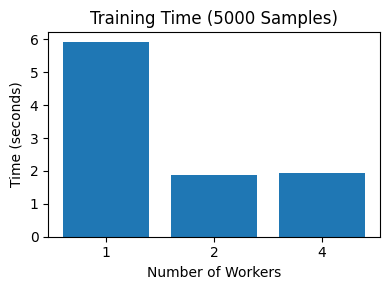

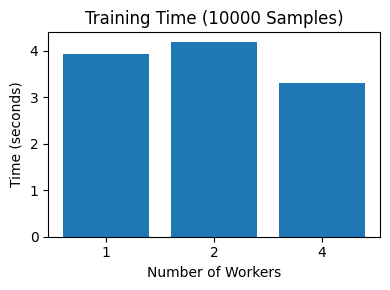

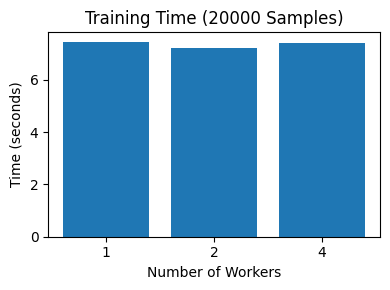

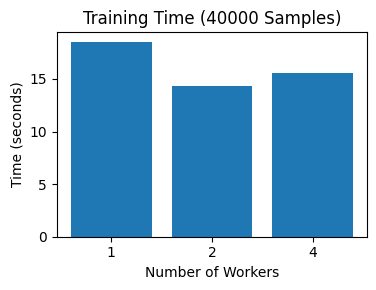

In [7]:
for i, n in enumerate(data_sizes):
    plt.figure(figsize=(4,3))
    times = [results[w][i] for w in workers_list]
    plt.bar([str(w) for w in workers_list], times)
    plt.xlabel('Number of Workers')
    plt.ylabel('Time (seconds)')
    plt.title(f'Training Time ({n} Samples)')
    plt.tight_layout()
    plt.show()

## Overall Time vs Dataset Size

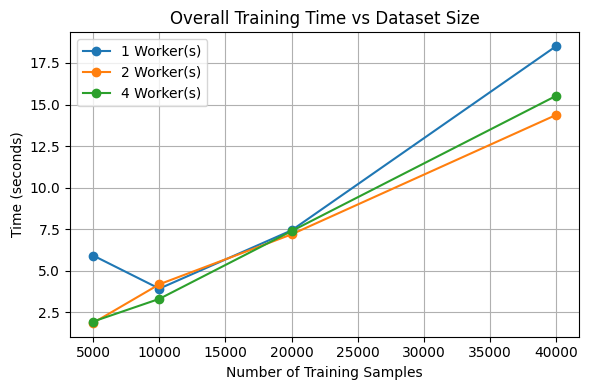

In [8]:
plt.figure(figsize=(6,4))
for w in workers_list:
    plt.plot(data_sizes, results[w], marker='o', label=f'{w} Worker(s)')
plt.xlabel('Number of Training Samples')
plt.ylabel('Time (seconds)')
plt.title('Overall Training Time vs Dataset Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Speedup vs Dataset Size

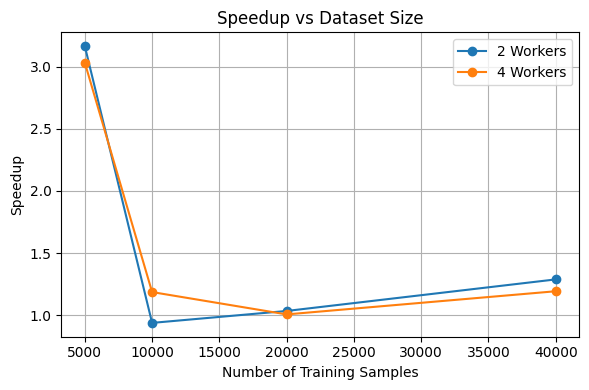

In [9]:
baseline = results[1]
plt.figure(figsize=(6,4))
for w in [2,4]:
    speedup = [baseline[i]/results[w][i] for i in range(len(data_sizes))]
    plt.plot(data_sizes, speedup, marker='o', label=f'{w} Workers')
plt.xlabel('Number of Training Samples')
plt.ylabel('Speedup')
plt.title('Speedup vs Dataset Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Parallel Efficiency vs Dataset Size

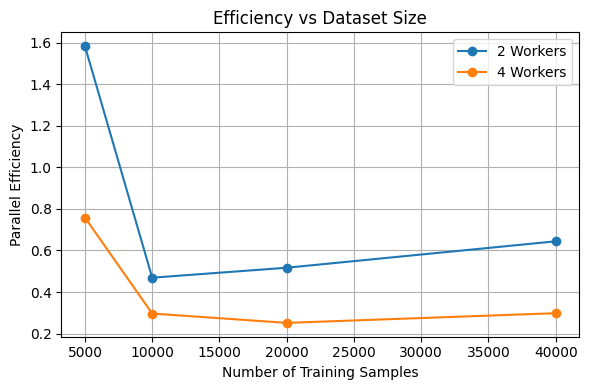

In [10]:
plt.figure(figsize=(6,4))
for w in [2,4]:
    efficiency = [(baseline[i]/results[w][i])/w for i in range(len(data_sizes))]
    plt.plot(data_sizes, efficiency, marker='o', label=f'{w} Workers')
plt.xlabel('Number of Training Samples')
plt.ylabel('Parallel Efficiency')
plt.title('Efficiency vs Dataset Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()